<a href="https://colab.research.google.com/github/Birat-Poudel/Conversational-Computational-Empathy/blob/master/Transformer_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import re

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data=pd.read_csv("/content/drive/MyDrive/test123.csv", encoding="latin-1")

In [ ]:
data.head()

,customer_query,intent,sentiment,responses,Unnamed: 4,Unnamed: 5
0,The noodles I purchased have a strange chemica...,complaint,negative,We apologize for the noodles with a chemical s...,NaN,NaN
1,The shoes I bought have a loose sole. It feels...,complaint,negative,We're sorry for the discolored strap. Please r...,NaN,NaN
2,The refrigerator I purchased has a dent on the...,complaint,negative,We apologize for the inconvenience. Please sha...,NaN,NaN
3,The slippers I received have a loose insole th...,complaint,negative,We apologize for the rough interior lining. Pl...,NaN,NaN
4,The necklace I received looks significantly di...,complaint,negative,Understood. Please provide us with your order ...,NaN,NaN


In [ ]:
data.shape

(10200, 6)

In [ ]:
one_hot = pd.get_dummies(data['sentiment'])
data.drop(['intent','sentiment','responses','Unnamed: 4', 'Unnamed: 5'], axis=1, inplace=True)
data = pd.concat([data, one_hot], axis=1)
data.head()

,customer_query,negative,neutral,positive
0,The noodles I purchased have a strange chemica...,1,0,0
1,The shoes I bought have a loose sole. It feels...,1,0,0
2,The refrigerator I purchased has a dent on the...,1,0,0
3,The slippers I received have a loose insole th...,1,0,0
4,The necklace I received looks significantly di...,1,0,0


In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [
                layers.Dense(ff_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    # removing contractions
    sentence = re.sub(r"i'm", "i am", sentence)
    sentence = re.sub(r"he's", "he is", sentence)
    sentence = re.sub(r"she's", "she is", sentence)
    sentence = re.sub(r"it's", "it is", sentence)
    sentence = re.sub(r"that's", "that is", sentence)
    sentence = re.sub(r"what's", "that is", sentence)
    sentence = re.sub(r"where's", "where is", sentence)
    sentence = re.sub(r"how's", "how is", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"won't", "will not", sentence)
    sentence = re.sub(r"can't", "cannot", sentence)
    sentence = re.sub(r"n't", " not", sentence)
    sentence = re.sub(r"n'", "ng", sentence)
    sentence = re.sub(r"'bout", "about", sentence)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

In [ ]:
X = data["customer_query"].values
y = data.drop(["customer_query"], axis=1).values

max_features = 20000
maxlen = 150
vocab_size = 20000

tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, maxlen=150)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(7140, 150) (7140, 3)
(3060, 150) (3060, 3)


In [ ]:
import pickle

# Save the tokenizer to a file using pickle
with open('/content/drive/MyDrive/Major/tokenizer-sentiment-analysis.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
print(y)

[[1 0 0]
 [1 0 0]
 [1 0 0]
 ...
 [0 0 1]
 [0 1 0]
 [0 1 0]]


In [ ]:
embed_dim = 100
num_heads = 2
ff_dim = 100

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(3, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [ ]:
model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)
history = model.fit(
    X_train, y_train, batch_size=128, epochs=10, validation_data=(X_test, y_test), callbacks=[early_stopping]
)

Epoch 1/10
56/56 [==============================] - 66s 1s/step - loss: 1.1037 - accuracy: 0.3643 - val_loss: 1.0792 - val_accuracy: 0.3578
Epoch 2/10
56/56 [==============================] - 60s 1s/step - loss: 1.0268 - accuracy: 0.4822 - val_loss: 0.8871 - val_accuracy: 0.5510
Epoch 3/10
56/56 [==============================] - 55s 976ms/step - loss: 0.4605 - accuracy: 0.8241 - val_loss: 0.2587 - val_accuracy: 0.9141
Epoch 4/10
56/56 [==============================] - 61s 1s/step - loss: 0.1513 - accuracy: 0.9497 - val_loss: 0.1738 - val_accuracy: 0.9431
Epoch 5/10
56/56 [==============================] - 56s 1s/step - loss: 0.0890 - accuracy: 0.9709 - val_loss: 0.1560 - val_accuracy: 0.9572
Epoch 6/10
56/56 [==============================] - 69s 1s/step - loss: 0.0634 - accuracy: 0.9807 - val_loss: 0.1679 - val_accuracy: 0.9516
Epoch 7/10
56/56 [==============================] - 64s 1s/step - loss: 0.0542 - accuracy: 0.9829 - val_loss: 0.1544 - val_accuracy: 0.9601
Epoch 8/10
56/56 

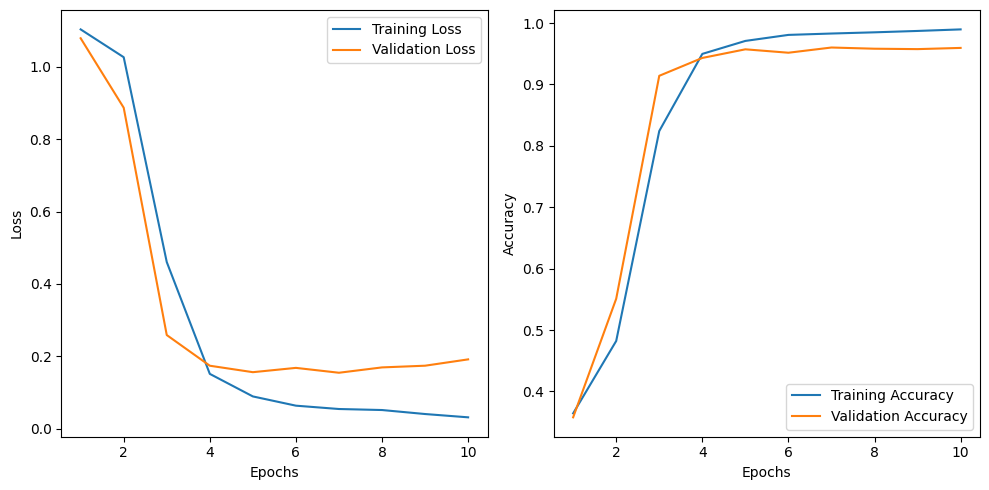

In [ ]:
import matplotlib.pyplot as plt

# Extract loss and accuracy from the training history
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot loss and accuracy
epochs = np.arange(1, len(loss) + 1)

plt.figure(figsize=(10, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Make predictions
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Generate classification report
report = classification_report(y_true_labels, y_pred_labels)
print(report)

96/96 [==============================] - 8s 81ms/step
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1095
           1       0.94      0.96      0.95      1025
           2       0.98      0.98      0.98       940

    accuracy                           0.96      3060
   macro avg       0.96      0.96      0.96      3060
weighted avg       0.96      0.96      0.96      3060



In [ ]:
model.save("/content/drive/MyDrive/Major/SentimentAnalysisFinal.h5")

In [ ]:
from sklearn.metrics import classification_report

Y_pred = model.predict_classes(X_test,batch_size = 128)
df_test = pd.DataFrame({'true': y_test.tolist(), 'pred':Y_pred})
df_test['true'] = df_test['true'].apply(lambda x: np.argmax(x))

print(classification_report(df_test.true, df_test.pred))

AttributeError: ignored

In [ ]:
text = ["The product is good."]
# Your website's checkout process is a bit confusing.
# The product is good.

text = preprocess_sentence(text[0])

text = tokenizer.texts_to_sequences(text)
text = pad_sequences(text, maxlen=150, dtype='int32', value=0)
sentiment = model.predict(text,batch_size=1,verbose = 2)[0]

print(sentiment)

if (np.argmax(sentiment) == 0):
  print("negative")
elif (np.argmax(sentiment) == 1):
  print("neutral")
else:
  print("positive")

21/21 - 0s - 349ms/epoch - 17ms/step
[0.12087816 0.28834277 0.590779  ]
positive
